# Timeseries Forecasting (LSTM)

## Load Libraries and Data

In [1]:
import logging
import io
import requests
import os
import pathlib
from zipfile import ZipFile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Restrict tensorflow output to errors
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Plot formatting
%matplotlib inline
sns.set()
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Data Source

Load the [Jena Climate dataset](https://keras.io/examples/timeseries/timeseries_weather_forecasting/) from the Max Planck Institute for Biogeochemistry.

In [2]:
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
filename = 'jena_climate_2009_2016.csv'
extract_dir = './Data/'

pathlib.Path(extract_dir).mkdir(parents=True, exist_ok=True)

zip_path = keras.utils.get_file(origin=url, fname=filename + '.zip')
zip_file = ZipFile(zip_path)
zip_file.extractall(path=extract_dir)

df = pd.read_csv(extract_dir + filename)

In [3]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

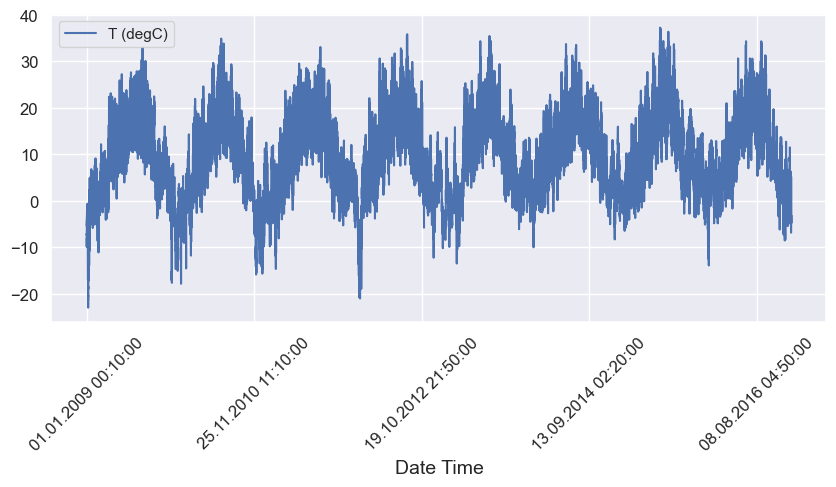

In [4]:
# Plot temperature for the full dataset
fig, ax = plt.subplots(figsize=(10, 4))
df.plot(x='Date Time', y='T (degC)', ax=ax)
plt.xticks(rotation=45)
plt.show()

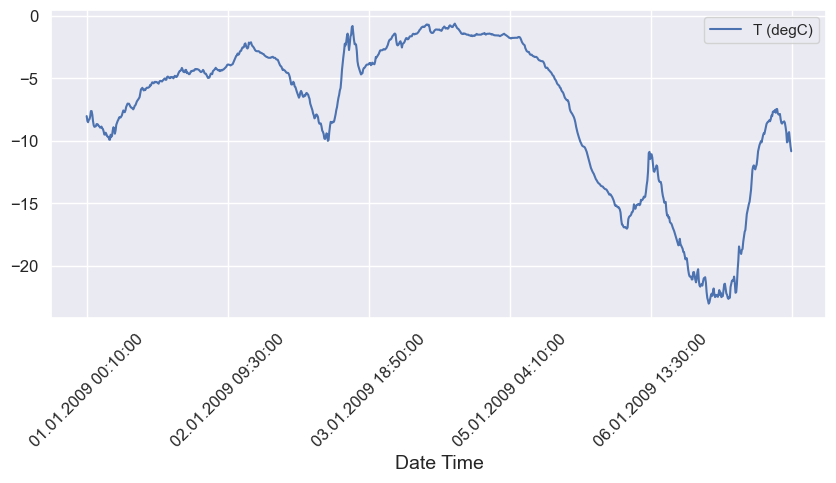

In [5]:
# Plot the first 1,000 instances
df_sub = df.head(1000)

fig, ax = plt.subplots(figsize=(10, 4))
df_sub.plot(x='Date Time', y='T (degC)', ax=ax)
plt.xticks(rotation=45)
plt.show()

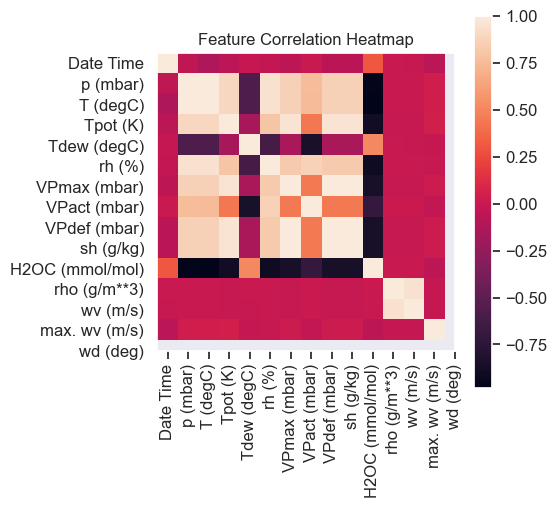

In [6]:
plt.matshow(df.corr(numeric_only=True))
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(df.shape[1]), df.columns)
plt.gca().grid(False)
plt.colorbar()
plt.title('Feature Correlation Heatmap')

plt.show()

### Setup Data for Training

In [7]:
titles = [
    "Pressure", "Temperature", "Temperature in Kelvin",
    "Temperature (dew point)", "Relative Humidity",
    "Saturation vapor pressure", "Vapor pressure",
    "Vapor pressure deficit", "Specific humidity",
    "Water vapor concentration", "Airtight", "Wind speed",
    "Maximum wind speed", "Wind direction in degrees",
]

feature_keys = df.columns[1:]
date_time_key = "Date Time"

In [8]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))

# Each step is one hour (not one measurement)
step = 6

# Track data for 720 measurements (120 hours)
past = 720

# Forecast 36 steps into the future (6 hours)
future = 36
learning_rate = 0.001
batch_size = 256
epochs = 10
patience = 5


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [9]:
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]

features = normalize(features.values, train_split)
features = pd.DataFrame(features)

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train, y_train, sequence_length=sequence_length,
    sampling_rate=step, batch_size=batch_size,
)

In [10]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val, y_val, sequence_length=sequence_length,
    sampling_rate=step, batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print('Input shape:', inputs.numpy().shape)
print('Target shape:', targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


2023-03-28 13:07:28.757939: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [12]:
path_checkpoint = 'model_checkpoint.h5'
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=0, patience=patience)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.2231
Epoch 1: val_loss improved from inf to 0.12005, saving model to model_checkpoint.h5
1172/1172 [==============================] - 59s 50ms/step - loss: 0.2229 - val_loss: 0.1200
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1006
Epoch 2: val_loss improved from 0.12005 to 0.11693, saving model to model_checkpoint.h5
1172/1172 [==============================] - 58s 50ms/step - loss: 0.1006 - val_loss: 0.1169
Epoch 3/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.0853
Epoch 3: val_loss did not improve from 0.11693
1172/1172 [==============================] - 59s 50ms/step - loss: 0.0853 - val_loss: 0.1200
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.0814
Epoch 4: val_loss improved from 0.11693 to 0.11248, saving model to model_checkpoint.h5
1172/1172 [==============================] - 58s 50ms/step - loss: 0.0814 - val_loss: 0.1125
Epoch

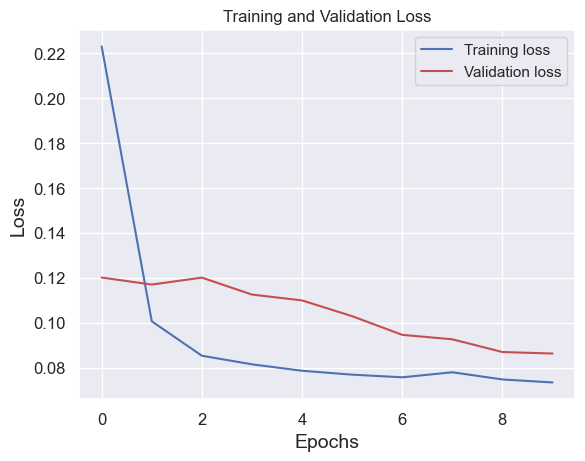

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

8/8 [==============================] - 0s 4ms/step


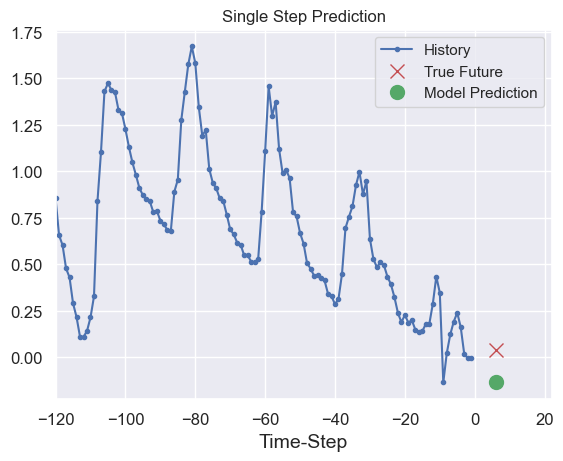

8/8 [==============================] - 0s 4ms/step


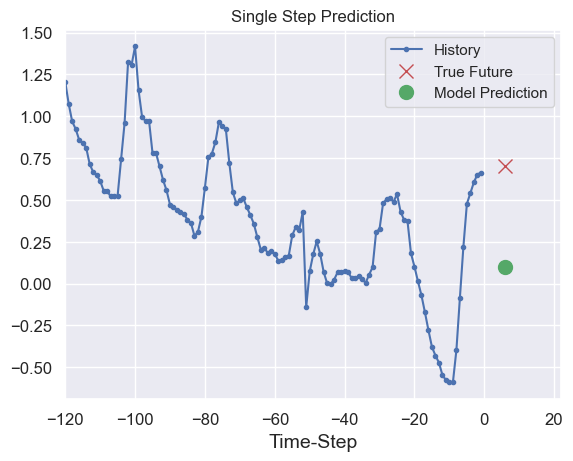

8/8 [==============================] - 0s 4ms/step


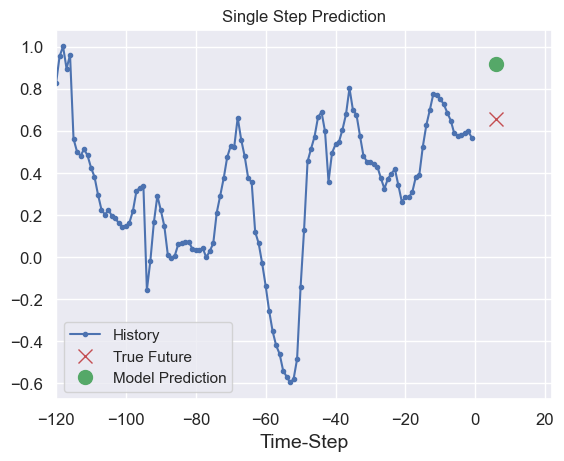

8/8 [==============================] - 0s 3ms/step


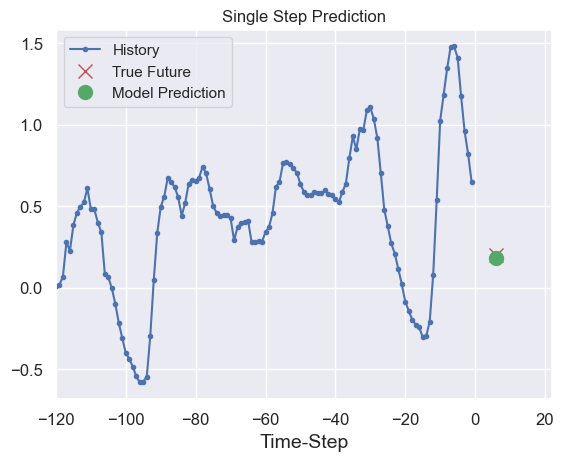

8/8 [==============================] - 0s 3ms/step


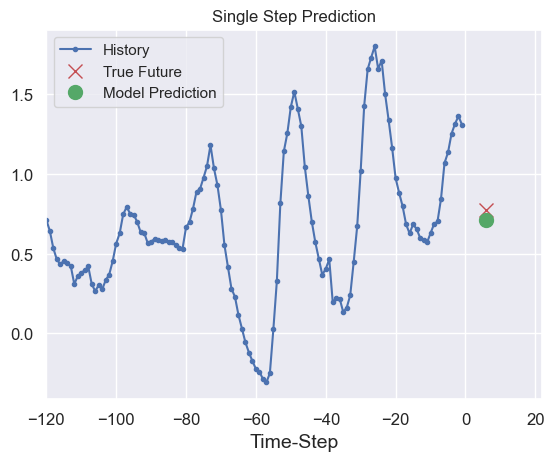

In [14]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        6,
        "Single Step Prediction",
    )